# Contingency Raise vs Energy Prices

Author: Matthew Davis

This notebook compares the quantities and prices of contingency raise and energy in Australia's electricity market.
This is for my masters thesis.

Warning: Need 10G - 20G of swap, for converting DISPATCHLOAD.

## Imports

In [1]:
import os
import urllib.request
import datetime as dt

import plotly.express as px
import plotly.io as pio
from nemosis import cache_compiler, defaults, static_table
import polars as pl
from polars import selectors as cs

# not needed directly,
# Plotly uses it to export graphs to disk
# Test it's installed.
import kaleido 


In [2]:
#fcas_duration = "6SEC"
#fcas_duration = "60SEC"
#fcas_duration = "5MIN"

In [3]:
nemosis_dir = '/home/matthew/Data/nemosis/'
data_dir = '/home/matthew/Data/fcas'

quantity_path = os.path.join(data_dir, "quantity.parquet")
rooftop_pv_deduplicated_path = os.path.join(data_dir, "rooftop-dedup.parquet")

temperature_folder = "/home/matthew/Documents/TSE/Thesis/fcas/temperature-data"

combined_output_path = os.path.join(data_dir, "combined.parquet")
combined_output_hourly_path = os.path.join(data_dir, f"combined-hourly.parquet")

In [4]:
GW_PER_MW = 1 / 1000

PERIODS_PER_H = 12

In [5]:
def parse_datetime(col: pl.Expr) -> pl.Expr:
    return col.str.strptime(pl.Datetime, '%Y/%m/%d %H:%M:%S').dt.replace_time_zone("Australia/Brisbane").dt.cast_time_unit("ms")

In [6]:
year = 2024

In [ ]:
# options: pio.templates
template = 'plotly_white'

## Download Data

In [21]:

end_time = dt.datetime(year, 12, 31, 23, 55, 0)
start_time = dt.datetime(year, 1, 1, 0, 5, 0)

fmt = '%Y/%m/%d %H:%M:%S'
tables = ['DISPATCHPRICE', 'DISPATCHLOAD', 'DISPATCHINTERCONNECTORRES', 'DISPATCHREGIONSUM', 'DISPATCHLOAD', 'ROOFTOP_PV_ACTUAL']

defaults.table_columns['DISPATCHLOAD'] += ['RAISE1SEC', 'LOWER1SEC']
defaults.table_columns['DISPATCHINTERCONNECTORRES'] += ['LOCALLY_CONSTRAINED_IMPORT', 'LOCALLY_CONSTRAINED_EXPORT']

for table in tables:
    cache_compiler(start_time.strftime(fmt), end_time.strftime(fmt), table, nemosis_dir, fformat='parquet')

INFO: Caching data for table DISPATCHPRICE
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRI

In [22]:
# fuel type and region of each generator
static_raw = pl.from_pandas(static_table('Generators and Scheduled Loads', nemosis_dir))

static = (
    static_raw
    .with_columns(
        pl.any_horizontal(
            (pl.col("Technology Type - Primary") == "Combustion"),
            (pl.col("Fuel Source - Primary") == "Hydro"),
            (pl.col("Technology Type - Descriptor").str.to_lowercase().str.contains("pump"))
        ).alias("INERTIAL")
    )
    .select(
        "DUID",
        pl.col("Region").alias("REGIONID"),
        "INERTIAL",
        pl.col("Dispatch Type").alias("DISPATCH_TYPE")
    )
    .lazy()
)
static.collect()

INFO: Retrieving static table Generators and Scheduled Loads


shape: (533, 4)
┌──────────┬──────────┬──────────┬────────────────────┐
│ DUID     ┆ REGIONID ┆ INERTIAL ┆ DISPATCH_TYPE      │
│ ---      ┆ ---      ┆ ---      ┆ ---                │
│ str      ┆ str      ┆ bool     ┆ str                │
╞══════════╪══════════╪══════════╪════════════════════╡
│ ADPBA1   ┆ SA1      ┆ false    ┆ Bidirectional Unit │
│ ADPBA1G  ┆ SA1      ┆ false    ┆ Generating Unit    │
│ ADPBA1L  ┆ SA1      ┆ false    ┆ Load               │
│ ADPMH1   ┆ SA1      ┆ true     ┆ Generating Unit    │
│ ADPPV1   ┆ SA1      ┆ false    ┆ Generating Unit    │
│ …        ┆ …        ┆ …        ┆ …                  │
│ YWNGAHYD ┆ VIC1     ┆ true     ┆ Generating Unit    │
│ YARWUN_1 ┆ QLD1     ┆ true     ┆ Generating Unit    │
│ YATSF1   ┆ VIC1     ┆ false    ┆ Generating Unit    │
│ YAWWF1   ┆ VIC1     ┆ false    ┆ Generating Unit    │
│ YENDWF1  ┆ VIC1     ┆ false    ┆ Generating Unit    │
└──────────┴──────────┴──────────┴────────────────────┘

## Price

In [13]:
df = (
    pl.scan_parquet(os.path.join(nemosis_dir, '*' + 'DISPATCHPRICE' + '*.parquet'), missing_columns='insert')
    .with_columns(
        pl.col('SETTLEMENTDATE').pipe(parse_datetime)
    )
    .filter(pl.col("SETTLEMENTDATE").dt.year() == year)
    .filter(pl.col("INTERVENTION") == 0)
    # .select("REGIONID", "RRP", "RAISE6SECRRP", "RAISE60SECRRP", "RAISE5MINRRP")
    .unpivot(
        on=["RAISE6SECRRP", "RAISE60SECRRP", "RAISE5MINRRP"],
        index=["REGIONID", "RRP"], # "SETTLEMENTDATE", 
        value_name="FCAS_PRICE",
        variable_name="FCAS_DURATION"
    )
    .rename({"RRP": "ENERGY_PRICE"})
    .with_columns(
        pl.col("FCAS_DURATION").str.strip_suffix("RRP").str.strip_prefix("RAISE")
    )
    .filter(pl.col("ENERGY_PRICE").is_between(10, 500))
    .filter(pl.col("FCAS_PRICE").is_between(10, 1000))
    .collect()
    .sample(n=10000)
    # .head(1000)
)
df

shape: (10_000, 4)
┌──────────┬──────────────┬───────────────┬────────────┐
│ REGIONID ┆ ENERGY_PRICE ┆ FCAS_DURATION ┆ FCAS_PRICE │
│ ---      ┆ ---          ┆ ---           ┆ ---        │
│ str      ┆ f64          ┆ str           ┆ f64        │
╞══════════╪══════════════╪═══════════════╪════════════╡
│ SA1      ┆ 300.01       ┆ 6SEC          ┆ 19.95      │
│ QLD1     ┆ 159.52685    ┆ 6SEC          ┆ 16.68      │
│ VIC1     ┆ 120.85489    ┆ 6SEC          ┆ 15.0       │
│ TAS1     ┆ 150.26       ┆ 6SEC          ┆ 28.95      │
│ TAS1     ┆ 120.19048    ┆ 6SEC          ┆ 93.02791   │
│ …        ┆ …            ┆ …             ┆ …          │
│ VIC1     ┆ 299.5        ┆ 6SEC          ┆ 19.95      │
│ TAS1     ┆ 120.28       ┆ 6SEC          ┆ 25.28524   │
│ TAS1     ┆ 115.1        ┆ 6SEC          ┆ 26.90591   │
│ VIC1     ┆ 157.10849    ┆ 6SEC          ┆ 41.93      │
│ TAS1     ┆ 108.02405    ┆ 6SEC          ┆ 23.61667   │
└──────────┴──────────────┴───────────────┴────────────┘

In [14]:
fig = px.scatter(
    df,
    x="ENERGY_PRICE",
    y="FCAS_PRICE", 
    facet_row="REGIONID",
    facet_col="FCAS_DURATION",
    opacity=0.1,
    trendline="ols"
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))


fig.show()

Hmm, the slopes are far below 1 (the expected slope).

Why?

- batteries and hydro have behavior not captured in my model
- higher energy prices change who is providing FCAS, so marginal costs increase
- FCAS prices are close to zero when the constraint is not binding
- dynamic considerations

## Quantity

Does demand for contingency raise vary with energy demand?

In [9]:
os.makedirs(os.path.dirname(quantity_path), exist_ok=True)

In [19]:
(
    pl.scan_parquet(os.path.join(nemosis_dir, '*' + 'DISPATCHLOAD' + '*.parquet'), missing_columns='insert')
    .with_columns(
        pl.col('SETTLEMENTDATE').pipe(parse_datetime),
        pl.when(
            (pl.col("INITIALMW") != 0) |
            (pl.col("TOTALCLEARED") != 0)
        ).then(pl.col("AVAILABILITY"))
        .otherwise(pl.lit(0))
        .alias("AVAILABILITY"),
    )
    .with_columns(
        pl.col("SETTLEMENTDATE").dt.year().alias("YEAR")
    )
    .filter(pl.col("YEAR") == year)
    .filter(pl.col("INTERVENTION") == 0)
    .select(pl.exclude("INTERVENTION"))

    .with_columns(
        (0.5 * (pl.col("INITIALMW") + pl.col("TOTALCLEARED"))).alias("ENERGY_MW")
    )
    .join(static, on="DUID", how="left")
    #.filter((pl.col("DISPATCH_TYPE") != "Load") | pl.col("DISPATCH_TYPE").is_null())
    #.filter(pl.col("DISPATCH_TYPE").is_not_null())
    .with_columns(
        pl.when(pl.col("DISPATCH_TYPE") == "Load")
        .then(-pl.col("ENERGY_MW"))
        .otherwise(pl.col("ENERGY_MW"))
        .alias("ENERGY_MW")
    )
    #.filter(pl.col("ENERGY_MW") > 0)
    .group_by("SETTLEMENTDATE")
    .agg(
        pl.col("ENERGY_MW").sum(),
        pl.col("RAISE1SEC").sum(),
        pl.col("RAISE6SEC").sum(),
        pl.col("RAISE60SEC").sum(),
        pl.col("RAISE5MIN").sum(),
        pl.col("AVAILABILITY").sum().alias("AVAILABILITY_SUM"),
        pl.col("AVAILABILITY").max().alias("AVAILABILITY_MAX"),
    )
    .unpivot(
        on=["RAISE1SEC", "RAISE6SEC", "RAISE60SEC", "RAISE5MIN"],
        index=["SETTLEMENTDATE", "ENERGY_MW", "AVAILABILITY_SUM", "AVAILABILITY_MAX"],
        value_name="FCAS_MW",
        variable_name="FCAS_DURATION"
    )
    .with_columns(
        pl.col("FCAS_DURATION").str.strip_suffix("RRP").str.strip_prefix("RAISE"),
        (pl.col("ENERGY_MW") * GW_PER_MW).alias("ENERGY_GW"),
        (pl.col("AVAILABILITY_SUM") * GW_PER_MW).alias("AVAILABILITY_SUM_GW"),       
    )
    .select(pl.exclude("ENERGY_MW", "AVAILABILITY_SUM"))
    .rename({"AVAILABILITY_MAX": "AVAILABILITY_MAX_MW"})
    .sort("SETTLEMENTDATE", "FCAS_DURATION")
    .with_columns(pl.col("SETTLEMENTDATE").dt.year().alias("YEAR"))
    .sink_parquet(quantity_path, compression="snappy")
    #.head(100)
    #.collect()
    #.sample(n=100000)
    # .head(1000)
)

pl.scan_parquet(quantity_path).head().collect()

shape: (5, 7)
┌─────────────────┬────────────────┬───────────────┬───────────┬───────────┬────────────────┬──────┐
│ SETTLEMENTDATE  ┆ AVAILABILITY_M ┆ FCAS_DURATION ┆ FCAS_MW   ┆ ENERGY_GW ┆ AVAILABILITY_S ┆ YEAR │
│ ---             ┆ AX_MW          ┆ ---           ┆ ---       ┆ ---       ┆ UM_GW          ┆ ---  │
│ datetime[ms,    ┆ ---            ┆ str           ┆ f64       ┆ f64       ┆ ---            ┆ i32  │
│ Australia/Brisb ┆ f64            ┆               ┆           ┆           ┆ f64            ┆      │
│ ane]            ┆                ┆               ┆           ┆           ┆                ┆      │
╞═════════════════╪════════════════╪═══════════════╪═══════════╪═══════════╪════════════════╪══════╡
│ 2024-01-01      ┆ 1154.0         ┆ 1SEC          ┆ 225.0     ┆ 19.261713 ┆ 25.774622      ┆ 2024 │
│ 00:05:00 AEST   ┆                ┆               ┆           ┆           ┆                ┆      │
│ 2024-01-01      ┆ 1154.0         ┆ 5MIN          ┆ 495.23091 ┆ 19.261713 ┆ 25.774622      ┆ 2024 │
│ 00:05:00 AEST   ┆                ┆               ┆           ┆           ┆                ┆      │
│ 2024-01-01      ┆ 1154.0         ┆ 60SEC         ┆ 651.91561 ┆ 19.261713 ┆ 25.774622      ┆ 2024 │
│ 00:05:00 AEST   ┆                ┆               ┆           ┆           ┆                ┆      │
│ 2024-01-01      ┆ 1154.0         ┆ 6SEC          ┆ 651.91562 ┆ 19.261713 ┆ 25.774622      ┆ 2024 │
│ 00:05:00 AEST   ┆                ┆               ┆           ┆           ┆                ┆      │
│ 2024-01-01      ┆ 1154.0         ┆ 1SEC          ┆ 225.0     ┆ 19.318774 ┆ 25.698168      ┆ 2024 │
│ 00:10:00 AEST   ┆                ┆               ┆           ┆           ┆                ┆      │
└─────────────────┴────────────────┴───────────────┴───────────┴───────────┴────────────────┴──────┘

In [40]:
fcas_quantity = (
    pl.scan_parquet(quantity_path)
    #.filter(pl.col("FCAS_DURATION") == fcas_duration)
    .select("SETTLEMENTDATE", "FCAS_MW", "FCAS_DURATION")
)

In [21]:
# it seems that units with DISPATCH_TYPE == null
# are ancillary-only units
# odd. But worth including these units
(
    pl.scan_parquet(os.path.join(nemosis_dir, '*' + 'DISPATCHLOAD' + '*.parquet'), missing_columns='insert')
    .group_by("DUID")
    .agg(
        pl.col("INITIALMW").mean().alias("AVG_POWER")
    )
    .join(static.with_columns(IN_STATIC=pl.lit(True)), on="DUID", how="left")
    #.select("DUID", "IN_STATIC", "DISPATCH_TYPE")
    
    .filter(pl.col("DISPATCH_TYPE").is_null())
    .sort("AVG_POWER")
    .tail()
    .collect()
)

shape: (5, 6)
┌───────┬────────────┬──────────┬──────────┬───────────────┬───────────┐
│ DUID  ┆ AVG_POWER  ┆ REGIONID ┆ INERTIAL ┆ DISPATCH_TYPE ┆ IN_STATIC │
│ ---   ┆ ---        ┆ ---      ┆ ---      ┆ ---           ┆ ---       │
│ str   ┆ f64        ┆ str      ┆ bool     ┆ str           ┆ bool      │
╞═══════╪════════════╪══════════╪══════════╪═══════════════╪═══════════╡
│ HWPS2 ┆ 162.519945 ┆ null     ┆ null     ┆ null          ┆ null      │
│ HWPS7 ┆ 168.183813 ┆ null     ┆ null     ┆ null          ┆ null      │
│ LD01  ┆ 210.775951 ┆ null     ┆ null     ┆ null          ┆ null      │
│ LD04  ┆ 273.017455 ┆ null     ┆ null     ┆ null          ┆ null      │
│ LD03  ┆ 299.798643 ┆ null     ┆ null     ┆ null          ┆ null      │
└───────┴────────────┴──────────┴──────────┴───────────────┴───────────┘

In [22]:
lf = pl.scan_parquet(quantity_path)
df = lf.cast({"YEAR": pl.String()}).collect()

/tmp/ipykernel_334815/2245315873.py:27: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




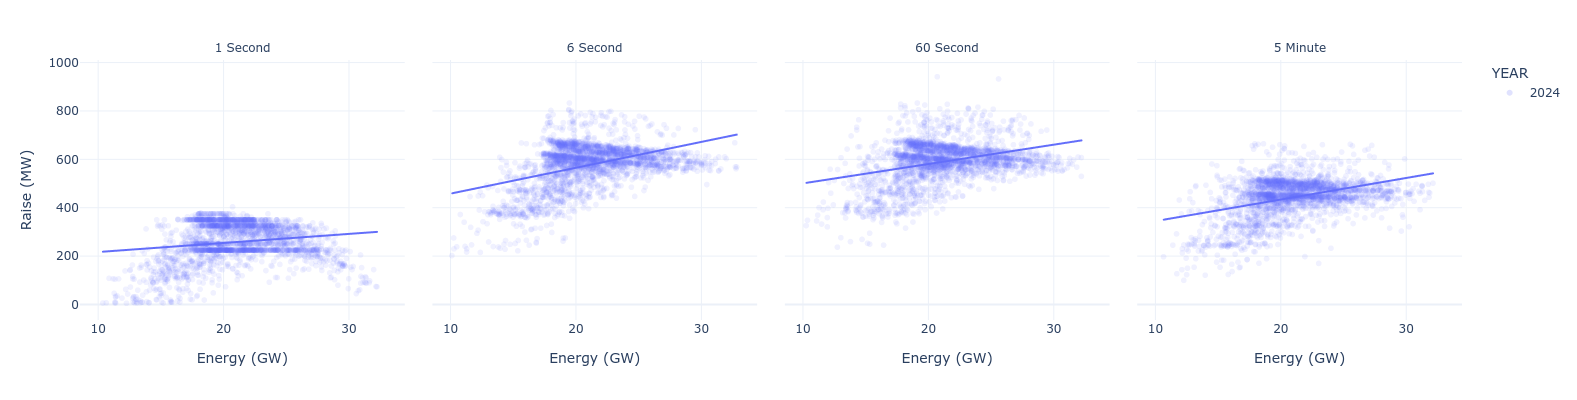

In [23]:
fig = px.scatter(
    df.sample(n=10000),
    x="ENERGY_GW",
    y="FCAS_MW", 
    #facet_row="REGIONID",
    facet_col="FCAS_DURATION",
    opacity=0.1,
    color="YEAR",
    trendline="ols",
    category_orders={"FCAS_DURATION": ["1SEC", "6SEC", "60SEC", "5MIN"]},
    labels = {
        "FCAS_MW": "Raise (MW)",
        "ENERGY_GW": "Energy (GW)",
        "AVAILABILITY_MAX_MW": "Largest Gen (MW)",
        "AVAILABILITY_SUM_GW": "Spinning Capacity (GW)",
    },
    template=template
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1].replace('SEC', ' Second').replace('MIN', ' Minute')))

fig.update_layout(height=400, width=800)
for ext in ['png', 'svg']:
    fig.write_image(f"raise-demand-slope-ENERGY_MW.{ext}")

fig.show()

In [ ]:

fig = px.scatter_3d(
    df.filter(pl.col("FCAS_DURATION") == "6SEC").sample(n=10000),
    x="ENERGY_GW",
    y="AVAILABILITY_SUM_GW",
    z="FCAS_MW", 
    #facet_row="REGIONID",
    #facet_col="FCAS_DURATION",
    opacity=0.01,
    #trendline="ols",
    category_orders={"FCAS_DURATION": ["1SEC", "6SEC", "60SEC", "5MIN"]},
    labels = {
        "FCAS_MW": "Raise (MW)",
        "ENERGY_GW": "Energy (GW)",
        "AVAILABILITY_MAX_MW": "Largest Gen (MW)",
        "AVAILABILITY_SUM_GW": "Spinning Capacity (GW)",
    },
    template=template
)

fig.update_traces(marker=dict(size=3))

fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1].replace('SEC', ' Second').replace('MIN', ' Minute')))

fig.show()

# Download and Prep Covariate data

We want:

- flows through each interconnection (between regions)
- whether they are available
- whether the AC ones are available

Generation by fuel type

- need to break down per generator, match to standing data, then aggregate

Weather

- temperature

Calendar:

- weekday vs weekend
- public holidays?

## Public Holidays

From here: https://data.gov.au/data/dataset/australian-holidays-machine-readable-dataset

In [23]:
url = "https://data.gov.au/data/dataset/b1bc6077-dadd-4f61-9f8c-002ab2cdff10/resource/33673aca-0857-42e5-b8f0-9981b4755686/download/australian-public-holidays-combined-2021-2025.csv"
holidays_path = os.path.join(data_dir, "holidays.csv")

In [24]:
if not os.path.exists(holidays_path):
    urllib.request.urlretrieve(url, holidays_path)
    
    with open(holidays_path, 'r') as f:
        for _ in range(2):
            print(f.readline())

In [25]:
holidays = (
    pl.scan_csv(holidays_path, schema_overrides={"Date": pl.String()})
    .select("Date")
    .unique()
    .select(
         pl.col("Date").str.strptime(pl.Date, "%Y%m%d").alias("DATE")
    )
)


## Interconnectors

Let's start with interconnectors. In table `DISPATCHINTERCONNECTORRES`.

In [26]:
dispatchinterconnectorres = (
    pl.scan_parquet(os.path.join(nemosis_dir, '*' + 'DISPATCHINTERCONNECTORRES' + '*.parquet'), missing_columns='insert')
    .filter(pl.col("INTERVENTION") == 0)
    .select(pl.exclude("INTERVENTION"))
    .with_columns(
        pl.col('SETTLEMENTDATE').pipe(parse_datetime)
    )
)

In [27]:
(
    dispatchinterconnectorres
    .head()
    .collect()
)

shape: (5, 8)
┌────────────┬────────────┬────────────┬────────────┬───────────┬──────────┬───────────┬───────────┐
│ SETTLEMENT ┆ INTERCONNE ┆ DISPATCHIN ┆ METEREDMWF ┆ MWFLOW    ┆ MWLOSSES ┆ LOCALLY_C ┆ LOCALLY_C │
│ DATE       ┆ CTORID     ┆ TERVAL     ┆ LOW        ┆ ---       ┆ ---      ┆ ONSTRAINE ┆ ONSTRAINE │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆ f64       ┆ f64      ┆ D_EXPORT  ┆ D_IMPORT  │
│ datetime[m ┆ str        ┆ i64        ┆ f64        ┆           ┆          ┆ ---       ┆ ---       │
│ s, Austral ┆            ┆            ┆            ┆           ┆          ┆ i64       ┆ i64       │
│ ia/Brisban ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ e]         ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══════════╪══════════╪═══════════╪═══════════╡
│ 2024-08-01 ┆ N-Q-MNSP1  ┆ 2024073124 ┆ -31.6      ┆ -30.3     ┆ 1.2708   ┆ 2         ┆ 0         │
│ 00:05:00   ┆            ┆ 1          ┆            ┆           ┆          ┆           ┆           │
│ AEST       ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ 2024-08-01 ┆ NSW1-QLD1  ┆ 2024073124 ┆ -372.6001  ┆ -387.6267 ┆ 2.77472  ┆ 0         ┆ 0         │
│ 00:05:00   ┆            ┆ 1          ┆            ┆ 4         ┆          ┆           ┆           │
│ AEST       ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ 2024-08-01 ┆ T-V-MNSP1  ┆ 2024073124 ┆ -153.2     ┆ -325.7739 ┆ 12.30797 ┆ 0         ┆ 0         │
│ 00:05:00   ┆            ┆ 1          ┆            ┆ 6         ┆          ┆           ┆           │
│ AEST       ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ 2024-08-01 ┆ V-S-MNSP1  ┆ 2024073124 ┆ -105.0     ┆ -81.0     ┆ 13.86957 ┆ 0         ┆ 0         │
│ 00:05:00   ┆            ┆ 1          ┆            ┆           ┆          ┆           ┆           │
│ AEST       ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ 2024-08-01 ┆ V-SA       ┆ 2024073124 ┆ -233.33037 ┆ -220.6739 ┆ 6.66624  ┆ 0         ┆ 0         │
│ 00:05:00   ┆            ┆ 1          ┆            ┆ 4         ┆          ┆           ┆           │
│ AEST       ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
└────────────┴────────────┴────────────┴────────────┴───────────┴──────────┴───────────┴───────────┘

In [28]:
interconnectors_max = (
    dispatchinterconnectorres
    .with_columns(
        pl.mean_horizontal("METEREDMWFLOW", "MWFLOW").alias("POWER")
    )
    .group_by("SETTLEMENTDATE")
    .agg(
        pl.col("POWER").abs().max().alias("BIGGEST_INTERCONNECTOR_FLOW_MW")
    )
)

In [29]:
# do they have outages often?
(
    dispatchinterconnectorres
    .group_by("INTERCONNECTORID")
    .agg(
        (pl.col("LOCALLY_CONSTRAINED_EXPORT") == 2).mean(),
        (pl.col("LOCALLY_CONSTRAINED_IMPORT") == 2).mean(),
    )
    .sort("LOCALLY_CONSTRAINED_EXPORT", "LOCALLY_CONSTRAINED_IMPORT")
    .collect()
)
    

shape: (6, 3)
┌──────────────────┬────────────────────────────┬────────────────────────────┐
│ INTERCONNECTORID ┆ LOCALLY_CONSTRAINED_EXPORT ┆ LOCALLY_CONSTRAINED_IMPORT │
│ ---              ┆ ---                        ┆ ---                        │
│ str              ┆ f64                        ┆ f64                        │
╞══════════════════╪════════════════════════════╪════════════════════════════╡
│ T-V-MNSP1        ┆ 0.005742                   ┆ 0.054466                   │
│ V-SA             ┆ 0.072077                   ┆ 0.055011                   │
│ V-S-MNSP1        ┆ 0.093818                   ┆ 0.364039                   │
│ NSW1-QLD1        ┆ 0.123321                   ┆ 0.013208                   │
│ N-Q-MNSP1        ┆ 0.214869                   ┆ 0.053309                   │
│ VIC1-NSW1        ┆ 0.370007                   ┆ 0.052333                   │
└──────────────────┴────────────────────────────┴────────────────────────────┘

In [30]:
(
    pl.scan_parquet("/home/matthew/Data/nemosis/PUBLIC_ARCHIVE#DISPATCHINTERCONNECTORRES#FILE01#202408010000.parquet")
    .head()
    .collect()
)

shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ SETTLEMEN ┆ INTERCONN ┆ DISPATCHI ┆ INTERVENT ┆ … ┆ MWFLOW    ┆ MWLOSSES ┆ LOCALLY_C ┆ LOCALLY_C │
│ TDATE     ┆ ECTORID   ┆ NTERVAL   ┆ ION       ┆   ┆ ---       ┆ ---      ┆ ONSTRAINE ┆ ONSTRAINE │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64      ┆ D_EXPORT  ┆ D_IMPORT  │
│ str       ┆ str       ┆ i64       ┆ i64       ┆   ┆           ┆          ┆ ---       ┆ ---       │
│           ┆           ┆           ┆           ┆   ┆           ┆          ┆ i64       ┆ i64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ 2024/08/0 ┆ N-Q-MNSP1 ┆ 202407312 ┆ 0         ┆ … ┆ -30.3     ┆ 1.2708   ┆ 2         ┆ 0         │
│ 1         ┆           ┆ 41        ┆           ┆   ┆           ┆          ┆           ┆           │
│ 00:05:00  ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ 2024/08/0 ┆ NSW1-QLD1 ┆ 202407312 ┆ 0         ┆ … ┆ -387.6267 ┆ 2.77472  ┆ 0         ┆ 0         │
│ 1         ┆           ┆ 41        ┆           ┆   ┆ 4         ┆          ┆           ┆           │
│ 00:05:00  ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ 2024/08/0 ┆ T-V-MNSP1 ┆ 202407312 ┆ 0         ┆ … ┆ -325.7739 ┆ 12.30797 ┆ 0         ┆ 0         │
│ 1         ┆           ┆ 41        ┆           ┆   ┆ 6         ┆          ┆           ┆           │
│ 00:05:00  ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ 2024/08/0 ┆ V-S-MNSP1 ┆ 202407312 ┆ 0         ┆ … ┆ -81.0     ┆ 13.86957 ┆ 0         ┆ 0         │
│ 1         ┆           ┆ 41        ┆           ┆   ┆           ┆          ┆           ┆           │
│ 00:05:00  ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ 2024/08/0 ┆ V-SA      ┆ 202407312 ┆ 0         ┆ … ┆ -220.6739 ┆ 6.66624  ┆ 0         ┆ 0         │
│ 1         ┆           ┆ 41        ┆           ┆   ┆ 4         ┆          ┆           ┆           │
│ 00:05:00  ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴──────────┴───────────┴───────────┘

In [31]:
interconnectors = (
    dispatchinterconnectorres
    .select(
        "SETTLEMENTDATE",
        pl.col("INTERCONNECTORID").str.replace_all('-', '_'),
        pl.struct([
            pl.any_horizontal(
                (pl.col("LOCALLY_CONSTRAINED_EXPORT") == 2),
                (pl.col("LOCALLY_CONSTRAINED_IMPORT") == 2),
            ).alias("INTERCONNECTOR_OUTAGE"),
            pl.mean_horizontal("METEREDMWFLOW", "MWFLOW").alias("POWER")
        ]).alias("VALUES")
    )
    .collect() # required for pivot
    .pivot(
        on="INTERCONNECTORID",
        index="SETTLEMENTDATE",
        values="VALUES"
    )
    .lazy()
    .with_columns([
        cs.exclude("SETTLEMENTDATE").struct.field("INTERCONNECTOR_OUTAGE").name.prefix("INTERCONNECTOR_OUTAGE_"),
        cs.exclude("SETTLEMENTDATE").struct.field("POWER").name.prefix("INTERCONNECTOR_POWER_")
    ])
    .drop(cs.exclude("SETTLEMENTDATE") & ~cs.starts_with(("INTERCONNECTOR_OUTAGE")))
    .join(interconnectors_max, on="SETTLEMENTDATE", how="inner")
)

## Generation

Let's use `DISPATCHREGIONSUM`

See my discussion [here](https://groups.google.com/g/nemosis-discuss/c/xBKKM2gGYPc).

Total inertial generation (at the end of each interval) is: `CLEAREDSUPPLY` - `SEMISCHEDULED_CLEARED`. (Perhaps also subtracting `NETIMPORT`. Although they should cancel out, other than losses, when we sum across regions.)

Total energy supplied: `DISPATCHABLELOAD` + `TOTALDEMAND`, then add rooftop solar (from another table)

In [32]:
dispatchregionsum = (
    pl.scan_parquet(os.path.join(nemosis_dir, '*' + 'DISPATCHREGIONSUM' + '*.parquet'), missing_columns='insert')
    .filter(pl.col("INTERVENTION") == 0)
    .select(pl.exclude("INTERVENTION"))
    .with_columns(
        pl.col('SETTLEMENTDATE').pipe(parse_datetime)
    )
    .filter(pl.col("SETTLEMENTDATE").dt.year() == year)
)

In [33]:
load_excl_rooftop = (
    dispatchregionsum
    .group_by("SETTLEMENTDATE")
    .agg(
        (pl.col("DISPATCHABLELOAD") + pl.col("TOTALDEMAND")).sum().alias("LOAD_EXCL_ROOFTOP")
    )
)

## Dispatchload

Per-generator energy

In [34]:
dispatchload = (
    pl.scan_parquet(os.path.join(nemosis_dir, '*' + 'DISPATCHLOAD' + '*.parquet'), missing_columns='insert')
    .filter(pl.col("INTERVENTION") == 0)
    .select(pl.exclude("INTERVENTION"))
    .with_columns(
        pl.col('SETTLEMENTDATE').pipe(parse_datetime)
    )
    .filter(pl.col("SETTLEMENTDATE").dt.year() == year)
)

In [35]:
generation = (
    dispatchload
    .with_columns(
        pl.mean_horizontal("INITIALMW", "TOTALCLEARED").alias("ENERGY_MW"), 
    )
    .select(
        "SETTLEMENTDATE", "DUID", 
        "ENERGY_MW",
        pl.when("ENERGY_MW" != 0)
        .then(pl.col("AVAILABILITY"))
        .otherwise(pl.lit(0))
        .alias("SPINNING_CAPACITY")
    )
    .join(static, how="left", on="DUID")
    #.filter((pl.col("DISPATCH_TYPE") != "Load") | pl.col("DISPATCH_TYPE").is_null())
    .with_columns(
        pl.when(pl.col("DISPATCH_TYPE") == "Load")
        .then(-pl.col("ENERGY_MW"))
        .otherwise(pl.col("ENERGY_MW"))
        .alias("ENERGY_MW")
    )
    .group_by("SETTLEMENTDATE")
    .agg(
        pl.col("ENERGY_MW").sum().alias("GENERATION_EXCL_ROOFTOP_MW"),
        (pl.col("SPINNING_CAPACITY") * pl.col("INERTIAL")).filter(pl.col("INERTIAL")).sum().alias("CONNECTED_INERTIA_MW"),
        pl.col("ENERGY_MW").max().alias("BIGGEST_RUNNING_GEN_MW")
    )
)

## Rooftop 

Rooftop solar is excluded from most other datasets. We need to get it from `ROOFTOP_PV_ACTUAL`, deduplicate, upsample.

In [36]:
(
    pl.scan_parquet(os.path.join(nemosis_dir, '*' + 'ROOFTOP_PV_ACTUAL' + '*.parquet'), missing_columns='insert')
    .with_columns(
        pl.col('INTERVAL_DATETIME').pipe(parse_datetime),
    )
    .filter(pl.col("INTERVAL_DATETIME").dt.year() == year)
    .filter(pl.col("REGIONID").cast(str).str.ends_with("1")) # delete sub-regions
    # deduplicate
    .sort(by=["TYPE", "QI", "LASTCHANGED"], descending=[False, True, True])
    .group_by(["REGIONID", "INTERVAL_DATETIME"])
    .first()
    .select(["REGIONID", "INTERVAL_DATETIME", "POWER"])
    .rename({"INTERVAL_DATETIME": "INTERVAL_END"})
    .with_columns([pl.col("INTERVAL_END").dt.offset_by("-30m").alias("INTERVAL_START")])
    .sort("INTERVAL_START", "REGIONID")
    .collect()  # required for .upsample() and fill_null, this data is small enough
    .upsample(
        time_column="INTERVAL_START",
        every=dt.timedelta(minutes=5),
        group_by="REGIONID",
        maintain_order=True,
    )
    .fill_null(strategy="forward", limit=30 // 5 - 1)
    .with_columns(
        INTERVAL_END=pl.col("INTERVAL_START").dt.offset_by("5m")
    )
    .filter(pl.col("REGIONID").is_not_null()) # bug with polars adds null rows
    .select(pl.exclude("INTERVAL_START"))
    # aggregate over regions
    .group_by("INTERVAL_END")
    .agg(pl.col("POWER").sum())
    .write_parquet(rooftop_pv_deduplicated_path)
)

In [37]:
rooftop = pl.scan_parquet(rooftop_pv_deduplicated_path)
rooftop.head().collect()

shape: (5, 2)
┌─────────────────────────────────┬───────────┐
│ INTERVAL_END                    ┆ POWER     │
│ ---                             ┆ ---       │
│ datetime[ms,                    ┆ f64       │
│ Australia/Brisbane]             ┆           │
╞═════════════════════════════════╪═══════════╡
│ 2024-02-07 03:00:00 AEST        ┆ 0.0       │
│ 2024-01-09 06:40:00 AEST        ┆ 2047.128  │
│ 2024-10-07 11:00:00 AEST        ┆ 11005.333 │
│ 2024-11-13 09:05:00 AEST        ┆ 6355.632  │
│ 2024-01-15 07:15:00 AEST        ┆ 2622.071  │
└─────────────────────────────────┴───────────┘

## Temperature

Manually downloaded from https://www.visualcrossing.com

Free account creation required. Quota is enough for one year of data per city per download day.

In [38]:
temperature_df = (
    pl.scan_csv(temperature_folder)
    .with_columns(
        pl.col("datetime").str.strptime(pl.Date(), "%Y-%m-%d"),
        pl.mean_horizontal("tempmax", "tempmin").alias("tempavg")
    )
    .collect()
    .pivot(
        on="name",
        index="datetime",
        values=["tempmax", "tempmin", "tempavg"]
    )
)

temperature_df = (
    temperature_df
    .rename({c: c.upper().replace("TEMP", "TEMP_") for c in temperature_df.collect_schema()})
    .rename({"DATETIME": "DATE"})
)

temperature_df

shape: (366, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ DATE      ┆ TEMP_MAX_ ┆ TEMP_MAX_ ┆ TEMP_MAX_ ┆ … ┆ TEMP_AVG_ ┆ TEMP_AVG_ ┆ TEMP_AVG_ ┆ TEMP_AVG │
│ ---       ┆ ADELAIDE  ┆ BRISBANE  ┆ HOBART    ┆   ┆ BRISBANE  ┆ HOBART    ┆ MELBOURNE ┆ _SYDNEY  │
│ date      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-01-0 ┆ 25.3      ┆ 24.1      ┆ 20.1      ┆ … ┆ 22.35     ┆ 16.6      ┆ 17.95     ┆ 21.25    │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-01-0 ┆ 25.7      ┆ 25.0      ┆ 20.6      ┆ … ┆ 23.05     ┆ 18.05     ┆ 21.25     ┆ 23.95    │
│ 2         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-01-0 ┆ 22.7      ┆ 30.4      ┆ 22.1      ┆ … ┆ 25.5      ┆ 18.35     ┆ 22.2      ┆ 24.05    │
│ 3         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-01-0 ┆ 29.0      ┆ 30.6      ┆ 17.3      ┆ … ┆ 26.6      ┆ 15.45     ┆ 19.6      ┆ 23.35    │
│ 4         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-01-0 ┆ 32.9      ┆ 30.4      ┆ 19.3      ┆ … ┆ 26.75     ┆ 16.05     ┆ 21.95     ┆ 22.4     │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2024-12-2 ┆ 19.0      ┆ 30.4      ┆ 24.6      ┆ … ┆ 25.15     ┆ 19.1      ┆ 18.6      ┆ 28.7     │
│ 7         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-12-2 ┆ 19.7      ┆ 31.4      ┆ 19.1      ┆ … ┆ 27.55     ┆ 16.2      ┆ 17.6      ┆ 23.0     │
│ 8         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-12-2 ┆ 22.3      ┆ 30.2      ┆ 22.3      ┆ … ┆ 26.95     ┆ 17.55     ┆ 18.4      ┆ 23.55    │
│ 9         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-12-3 ┆ 26.2      ┆ 30.0      ┆ 23.6      ┆ … ┆ 26.6      ┆ 18.35     ┆ 20.35     ┆ 23.4     │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024-12-3 ┆ 25.1      ┆ 29.4      ┆ 20.8      ┆ … ┆ 25.3      ┆ 16.8      ┆ 20.4      ┆ 24.6     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## Combine

- `fcas_quantity` has `SETTLEMENTDATE`, `FCAS_MW`
- `rooftop` has `INTERVAL_END`, `POWER`
- `generation` has `SETTLEMENTDATE` and `LOAD_EXCL_ROOFTOP`, and `GENERATION_EXCL_ROOFTOP_MW`
- `inertial_capacity` has `SETTLEMENTDATE` and `CONNECTED_INERTIA_MW`
- `interconnectors` has `SETTLEMENTDATE` and `BIGGEST_INTERCONNECTOR_FLOW_MW`
- `holidays` has column `DATE` (sparse dataset, no non-holiday days present)
- `temperature_df` has columns `DATE`, and `TEMP_*`

In [41]:
(
    fcas_quantity
    .select("FCAS_DURATION", "SETTLEMENTDATE", "FCAS_MW")
    .join(rooftop, left_on="SETTLEMENTDATE", right_on="INTERVAL_END", how="inner")
    .rename({"POWER": "ROOFTOP_POWER_MW"})
    .join(load_excl_rooftop, on="SETTLEMENTDATE", how="inner")
    .join(generation, on="SETTLEMENTDATE", how="inner")
    .with_columns(
        (pl.col("ROOFTOP_POWER_MW") + pl.col("GENERATION_EXCL_ROOFTOP_MW")).alias("TOTAL_GENERATION_MW")
    )
    .join(interconnectors, on="SETTLEMENTDATE", how="inner")
    .with_columns(
        pl.max_horizontal("BIGGEST_INTERCONNECTOR_FLOW_MW", "BIGGEST_RUNNING_GEN_MW").alias("BIGGEST_CONTINGENCY_MW")
    )
    .rename({"SETTLEMENTDATE": "INTERVAL_END"})
    .with_columns(
        pl.col("INTERVAL_END").dt.offset_by("-5m").alias("INTERVAL_START")
    )
    .with_columns(pl.col("INTERVAL_START").dt.date().alias("DATE"))
    .join(holidays.with_columns(pl.lit(True).alias("IS_HOLIDAY")), on="DATE", how="left")
    .with_columns(
        pl.col("INTERVAL_START").dt.to_string("%a").str.to_uppercase().alias("DAY_OF_WEEK"),
        pl.col("INTERVAL_START").dt.is_business_day().alias("IS_WEEKDAY"),
        pl.col("IS_HOLIDAY").fill_null(value=pl.lit(False))
    )
    .join(temperature_df.lazy(), on="DATE", how="inner")
    .sort("INTERVAL_END")
    .sink_parquet(combined_output_path)
)

In [42]:
combined_output_path

'/home/matthew/Data/fcas/combined.parquet'

In [43]:
(
    pl.scan_parquet(combined_output_path)
    .head()
    .collect_schema()
)

Schema([('FCAS_DURATION', String),
        ('INTERVAL_END',
         Datetime(time_unit='ms', time_zone='Australia/Brisbane')),
        ('FCAS_MW', Float64),
        ('ROOFTOP_POWER_MW', Float64),
        ('LOAD_EXCL_ROOFTOP', Float64),
        ('GENERATION_EXCL_ROOFTOP_MW', Float64),
        ('CONNECTED_INERTIA_MW', Float64),
        ('BIGGEST_RUNNING_GEN_MW', Float64),
        ('TOTAL_GENERATION_MW', Float64),
        ('INTERCONNECTOR_OUTAGE_N_Q_MNSP1', Boolean),
        ('INTERCONNECTOR_OUTAGE_NSW1_QLD1', Boolean),
        ('INTERCONNECTOR_OUTAGE_T_V_MNSP1', Boolean),
        ('INTERCONNECTOR_OUTAGE_V_S_MNSP1', Boolean),
        ('INTERCONNECTOR_OUTAGE_V_SA', Boolean),
        ('INTERCONNECTOR_OUTAGE_VIC1_NSW1', Boolean),
        ('BIGGEST_INTERCONNECTOR_FLOW_MW', Float64),
        ('BIGGEST_CONTINGENCY_MW', Float64),
        ('INTERVAL_START',
         Datetime(time_unit='ms', time_zone='Australia/Brisbane')),
        ('DATE', Date),
        ('IS_HOLIDAY', Boolean),
        ('DAY_O

In [44]:
combined_output_path

'/home/matthew/Data/fcas/combined.parquet'

In [45]:
(
    pl.scan_parquet(combined_output_path)
    .sort("INTERVAL_START")
    .group_by_dynamic(index_column="INTERVAL_START", group_by="FCAS_DURATION", every = "1h")
    .agg([
        pl.col(pl.Float64, pl.Float32).mean(),
        pl.col("INTERVAL_END").max(),
        pl.col(pl.Date).first(),
        pl.col(pl.Boolean).first(),
        pl.col(pl.String).first(),
    ])
    .sink_parquet(combined_output_hourly_path)
)

pl.scan_parquet(combined_output_hourly_path).head().collect()

shape: (5, 37)
┌────────────┬───────────┬─────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ FCAS_DURAT ┆ INTERVAL_ ┆ FCAS_MW ┆ ROOFTOP_P ┆ … ┆ INTERCONN ┆ IS_HOLIDA ┆ IS_WEEKDA ┆ DAY_OF_WE │
│ ION        ┆ START     ┆ ---     ┆ OWER_MW   ┆   ┆ ECTOR_OUT ┆ Y         ┆ Y         ┆ EK        │
│ ---        ┆ ---       ┆ f64     ┆ ---       ┆   ┆ AGE_VIC1_ ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ datetime[ ┆         ┆ f64       ┆   ┆ NSW…      ┆ bool      ┆ bool      ┆ str       │
│            ┆ ms, Austr ┆         ┆           ┆   ┆ ---       ┆           ┆           ┆           │
│            ┆ alia/Bris ┆         ┆           ┆   ┆ bool      ┆           ┆           ┆           │
│            ┆ bane]     ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
╞════════════╪═══════════╪═════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1SEC       ┆ 2024-01-0 ┆ 225.0   ┆ 0.0       ┆ … ┆ null      ┆ true      ┆ true      ┆ MON       │
│            ┆ 1         ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 00:00:00  ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ AEST      ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 1SEC       ┆ 2024-01-0 ┆ 225.0   ┆ 0.0       ┆ … ┆ null      ┆ true      ┆ true      ┆ MON       │
│            ┆ 1         ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 01:00:00  ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ AEST      ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 1SEC       ┆ 2024-01-0 ┆ 225.0   ┆ 0.0       ┆ … ┆ null      ┆ true      ┆ true      ┆ MON       │
│            ┆ 1         ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 02:00:00  ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ AEST      ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 1SEC       ┆ 2024-01-0 ┆ 225.0   ┆ 0.0       ┆ … ┆ null      ┆ true      ┆ true      ┆ MON       │
│            ┆ 1         ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 03:00:00  ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ AEST      ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 1SEC       ┆ 2024-01-0 ┆ 225.0   ┆ 1.252     ┆ … ┆ null      ┆ true      ┆ true      ┆ MON       │
│            ┆ 1         ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 04:00:00  ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ AEST      ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴───────────┴─────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [46]:
combined_output_hourly_path

'/home/matthew/Data/fcas/combined-hourly.parquet'

# Plots

Try again to get that Simpson's paradox

Plot a few different X values.

* A: `DISPATCHLOAD`:`INITIALMW` + `DISPATCHLOAD`:`TOTALCLEARED`
* B: `DISPATCHLOAD`:`INITIALMW` + `DISPATCHLOAD`:`TOTALCLEARED` + rooftop
* C: `DISPATCHREGIONSUM`:`TOTALDEMAND`
* D: `DISPATCHREGIONSUM`:`TOTALDEMAND` + rooftop
* E: `DISPATCHREGIONSUM`:`TOTALDEMAND` + `DISPATCHREGIONSUM`:`DISPATCHABLELOAD`
* F: `DISPATCHREGIONSUM`:`TOTALDEMAND` + `DISPATCHREGIONSUM`:`DISPATCHABLELOAD` + rooftop
* G: `DISPATCHREGIONSUM`:`DISPATCHABLEGENERATION`

In [47]:
dispatchregionsum.collect_schema().keys()

odict_keys(['SETTLEMENTDATE', 'REGIONID', 'DISPATCHINTERVAL', 'TOTALDEMAND', 'AVAILABLEGENERATION', 'AVAILABLELOAD', 'DEMANDFORECAST', 'DISPATCHABLEGENERATION', 'DISPATCHABLELOAD', 'NETINTERCHANGE', 'EXCESSGENERATION', 'LOWER5MINLOCALDISPATCH', 'LOWER60SECLOCALDISPATCH', 'LOWER6SECLOCALDISPATCH', 'RAISE5MINLOCALDISPATCH', 'RAISE60SECLOCALDISPATCH', 'RAISE6SECLOCALDISPATCH', 'INITIALSUPPLY', 'CLEAREDSUPPLY', 'LOWERREGLOCALDISPATCH', 'RAISEREGLOCALDISPATCH', 'TOTALINTERMITTENTGENERATION', 'DEMAND_AND_NONSCHEDGEN', 'UIGF', 'SEMISCHEDULE_CLEAREDMW', 'SEMISCHEDULE_COMPLIANCEMW'])

In [51]:
dl = (
    dispatchload
    .join(static, how="inner", on="DUID")
    .filter((pl.col("DISPATCH_TYPE") != "Load") | pl.col("DISPATCH_TYPE").is_null())
    .with_columns(
        pl.mean_horizontal("INITIALMW", "TOTALCLEARED").alias("DL_ENERGY_MW"), 
    )
    #.filter(pl.col("DL_ENERGY_MW") > 0)
    .group_by("SETTLEMENTDATE")
    .agg(
        pl.col("DL_ENERGY_MW").sum()
    )
)

load_excl_rooftop = (
    dispatchregionsum
    .group_by("SETTLEMENTDATE")
    .agg(
        pl.col("TOTALDEMAND").sum(),
        pl.col("DISPATCHABLELOAD").sum(),
        pl.col("DISPATCHABLEGENERATION").sum(),
    )
)

df = (
    fcas_quantity
    .select("FCAS_DURATION", "SETTLEMENTDATE", "FCAS_MW")
    .join(rooftop.rename({"POWER": "ROOFTOP_POWER_MW"}), 
          left_on="SETTLEMENTDATE", right_on="INTERVAL_END", how="inner")
    .join(dl, on="SETTLEMENTDATE", how="inner")
    .join(load_excl_rooftop, on="SETTLEMENTDATE", how="inner")
    .with_columns(
        pl.col("DL_ENERGY_MW").alias("A"),
        (pl.col("DL_ENERGY_MW") + pl.col("ROOFTOP_POWER_MW")).alias("B"),
        pl.col("TOTALDEMAND").alias("C"),
        (pl.col("TOTALDEMAND") + pl.col("ROOFTOP_POWER_MW")).alias("D"),
        (pl.col("TOTALDEMAND") + pl.col("DISPATCHABLELOAD")).alias("E"),
        (pl.col("TOTALDEMAND") + pl.col("DISPATCHABLELOAD") + pl.col("ROOFTOP_POWER_MW")).alias("F"),
        pl.col("DISPATCHABLEGENERATION").alias("G"),
    )
    .unpivot(
        on=("A", "B", "C", "D", "E", "F", "G"),
        index = ("FCAS_MW", "FCAS_DURATION"),
        variable_name = "METRIC",
        value_name = "POWER"
    )
    .sort("METRIC")
    .collect()
)

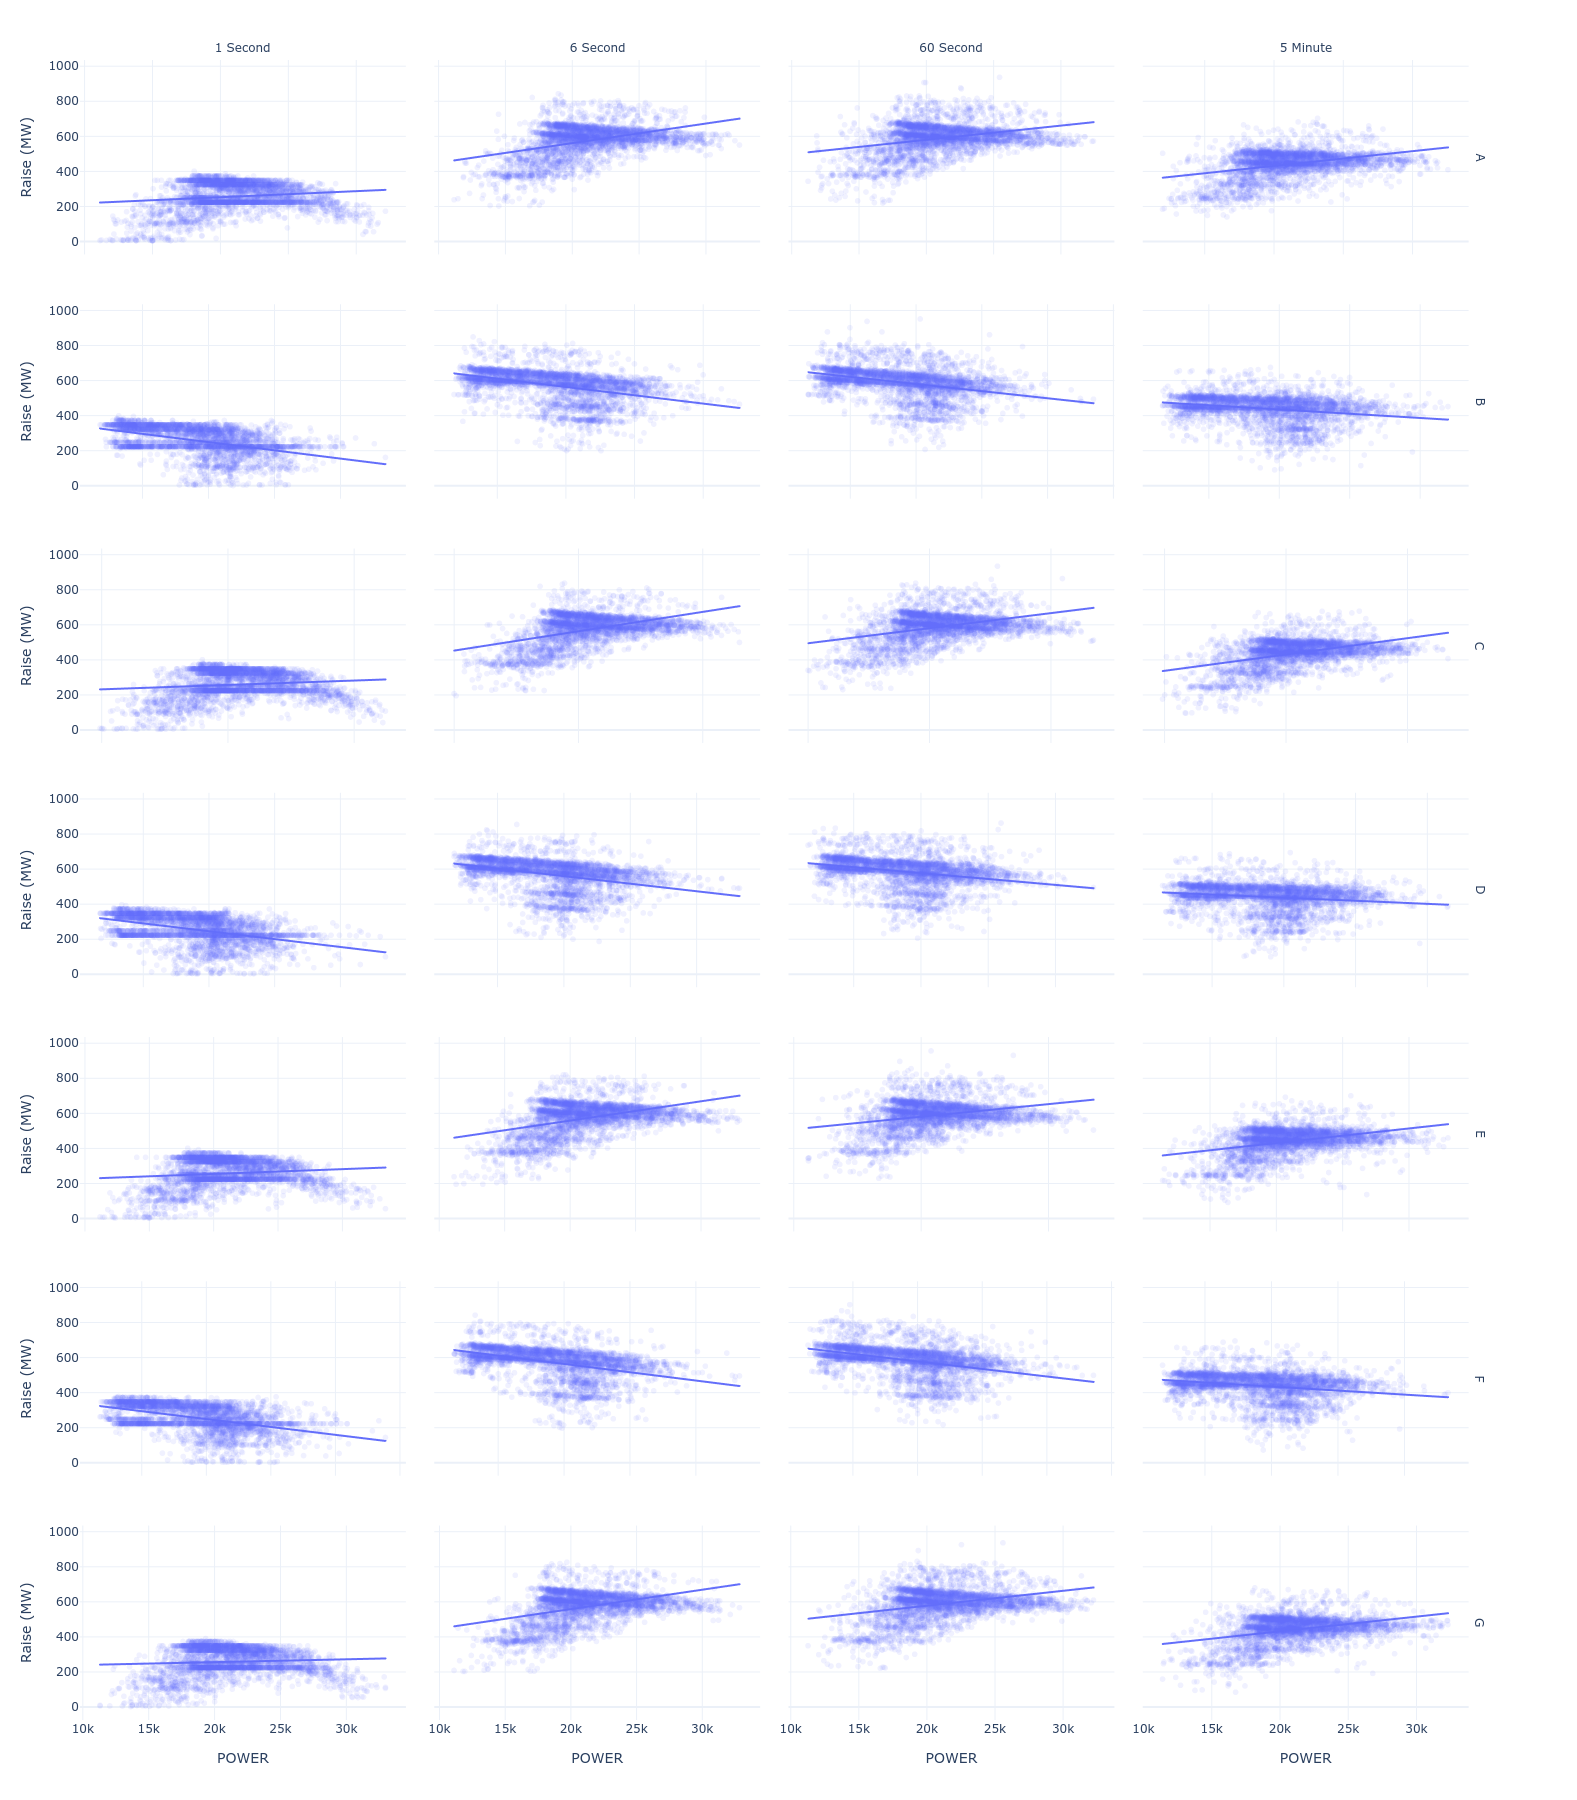

In [53]:

fig = px.scatter(
    df.sample(n=100000).sort("METRIC"),
    x="POWER",
    y="FCAS_MW", 
    facet_row="METRIC",
    facet_col="FCAS_DURATION",
    opacity=0.1,
    trendline="ols",
    category_orders={"FCAS_DURATION": ["1SEC", "6SEC", "60SEC", "5MIN"]},
    labels = {
        "FCAS_MW": "Raise (MW)",
        "ENERGY_GW": "Energy (GW)",
        "AVAILABILITY_MAX_MW": "Largest Gen (MW)",
        "AVAILABILITY_SUM_GW": "Spinning Capacity (GW)",
    },
    template=template
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1].replace('SEC', ' Second').replace('MIN', ' Minute')))

fig.update_xaxes(matches=None)
fig.update_layout(height=1800, width=1200)
# for ext in ['png', 'svg']:
#     fig.write_image(f"raise-demand-slope-{x}.{ext}")

fig.show()